In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const
import frame_transformations as ft
import agis

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

# Steps: 
* Source detection
* scan

Create three example stars from real data. The Source object takes as inputs:

> Source('name', $\alpha$, $\delta$, parallax, $\mu_{\alpha}$, $\mu_{\delta}$, $\mu_{r}$)

with units: [string, deg, deg, mas, mas/yr, mas/yr, km/s]

Once the satellite and its correspondent attitude object is created, we need to create a scanner. At the moment, the scaner is only able to perform the search of one single star in the sky.  
_**Scanner:**_
The scanner takes in two parameters. The first does a scan of the sky taking the dot product of the x-axis of the scanner (with respect to the LMN-frame) and the star's position (also in LMN). Since the scanning law has an almost perfect coverage of the sky (would be interesting to do a density plot of where it scans more in the future), it selects the times when the star is in this circle field of view. For this example we set it to 20 deg. The second input parameters sets the z-axis value threshold for the scanner ccd dimentions. That is to say, the height of the scanning line that swaps the sky.  
_**To scan:**_
Firstly, the coarse scan is performed, using the desire satellite and the star that we want to scan.
Secondly, we search for the optimized solutions with the fine scan, which uses the data from the coarse scan.

In [58]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end = 365
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
sirio = Source("sirio", 101.28, -16.7161, 379.21, -546.05, -1223.14, -7.6)
print('Source created')
scanSirio = Scanner() 
print('Scanner created')

Sat created
Source created
Scanner created


In [63]:
scanSirio.start(gaia, sirio, ti=t_init, tf=t_end)
print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)

Starting wide_scan with time from 0 to 365 days
wide scan lasted 3.96047306060791 seconds, found 948 times with wide scan
Finished wide_scan!
Coarse scan lasted 1.266059160232544 seconds, found 152 times with coarse scan
Finished coarse_scan!
time_step: 0.001736111111111111
phi_minimization lasted 1.7685887813568115 seconds
wide scan lasted 0.022138118743896484 seconds
original obs_times: 14
identical duplicates removal obs_time: 14
Finished fine_scan!
How many wide times?  948
How many coarse times?  152
How many observation time?  14
How many roots?  14


In [60]:
agis.compute_du_ds_tilde(source = sirio, satellite = gaia, observation_times= [1,2])

shape tmp: (1, 1)
shape tmp: (1, 1)
du_dalpha.shape: (2, 3)
du_ds.shape: (5, 2, 3)


array([[[-0.980683  , -0.19560383,  0.        ],
        [-0.980683  , -0.19560383,  0.        ]],

       [[-0.05626146,  0.28207351,  0.95774171],
        [-0.05626146,  0.28207351,  0.95774171]],

       [[-0.02264003, -0.92419321, -0.93313907],
        [-0.04527334, -0.93063049, -0.94851957]],

       [[-0.980683  , -0.19560383,  0.        ],
        [-1.96136599, -0.39120767,  0.        ]],

       [[-0.05626146,  0.28207351,  0.95774171],
        [-0.11252293,  0.56414702,  1.91548342]]])

# Plots:

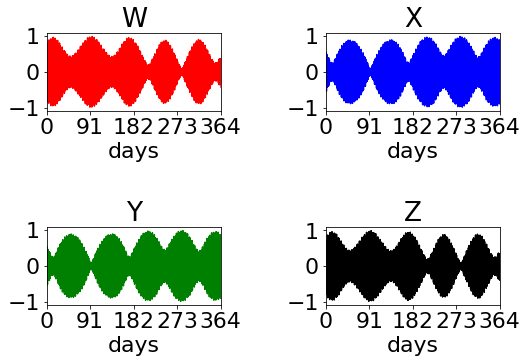

In [61]:
plot_attitude(gaia,t_init,t_end)

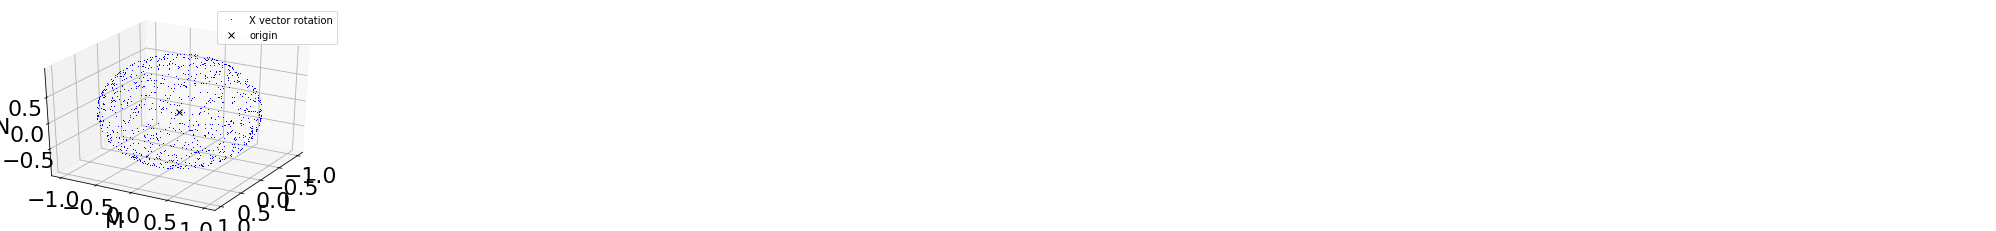

In [18]:
plot_3D_scanner_pos(gaia, 'X', t_init, t_end, 1000, elevation=30, azimuth=30)
#plot_3D_scanner_pos(gaia, 'Z', 0, myTime, 1000)
def my_func(elev, azim):
    plot_3D_scanner_pos(gaia, 'X', t_init, t_end, 1000, elevation=elev, azimuth=azim)
# interact(my_func, elev=widgets.IntSlider(min=0,max=90,step=1,value=20),
#         azim=widgets.IntSlider(min=0,max=90,step=1,value=20))

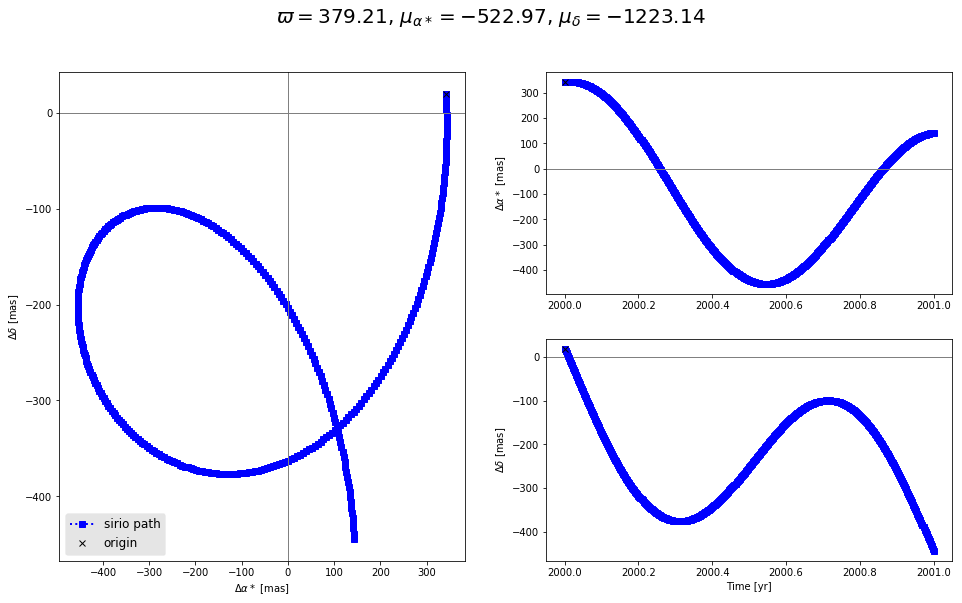

In [7]:
#Plot of the star trayectory from G-frame 
#(i.e. at a point moment around the sun in ecliptic plane in circular orbit of 1 AU).
plot_stars_trajectory(sirio, gaia)

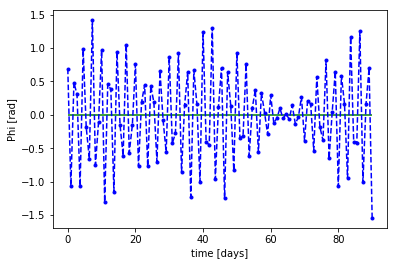

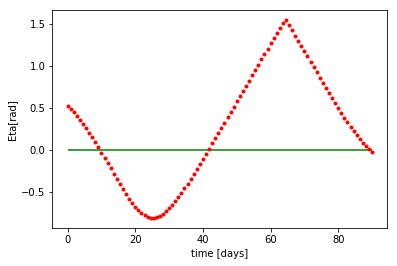

In [11]:
plot_phi(sirio, gaia, ti=0, tf=90, n=100)

def myFunc(day):
    p = plot_eta_over_phi_day(source=sirio, att=gaia, ti=0, tf=90, day=day)

#interact(myFunc, day=(0,90))

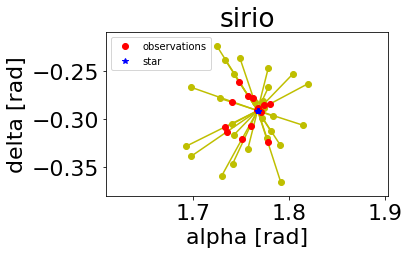

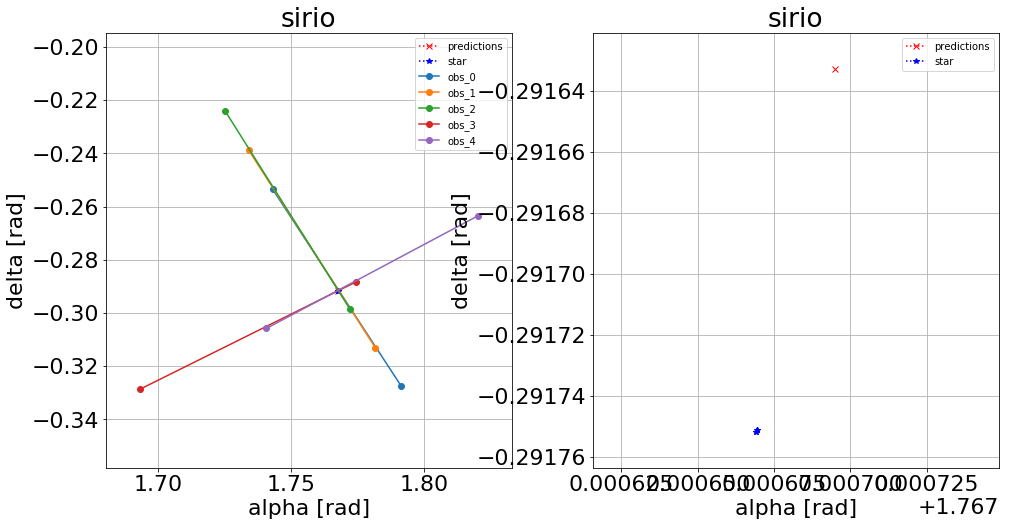

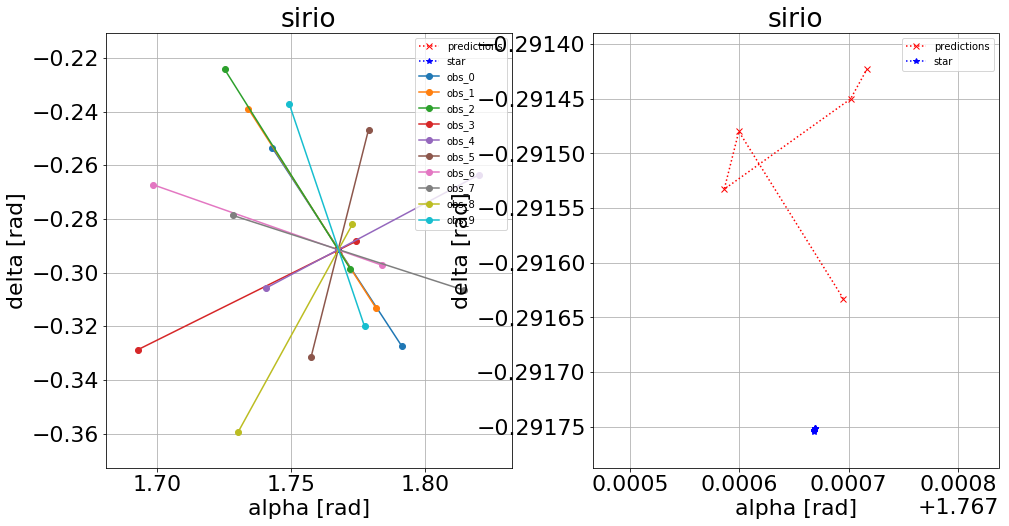

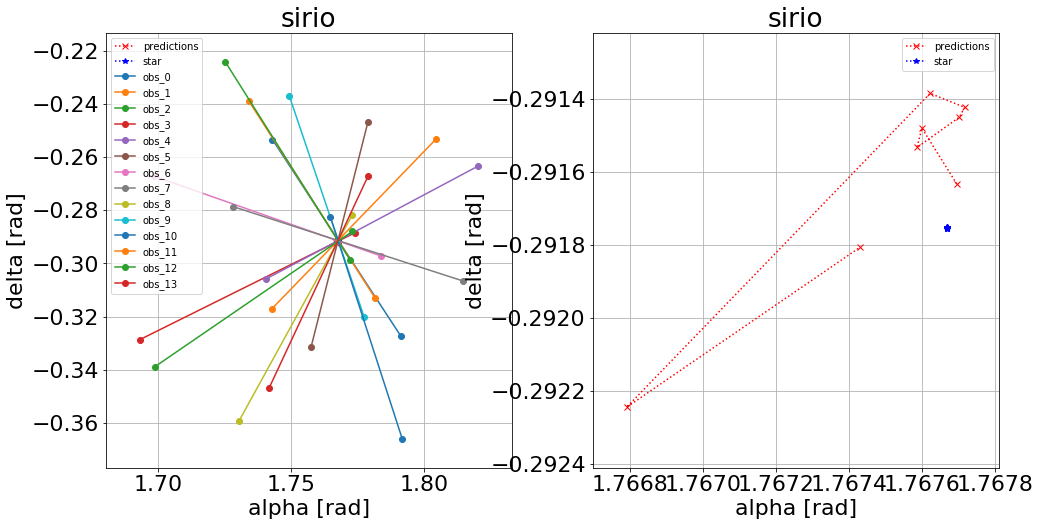

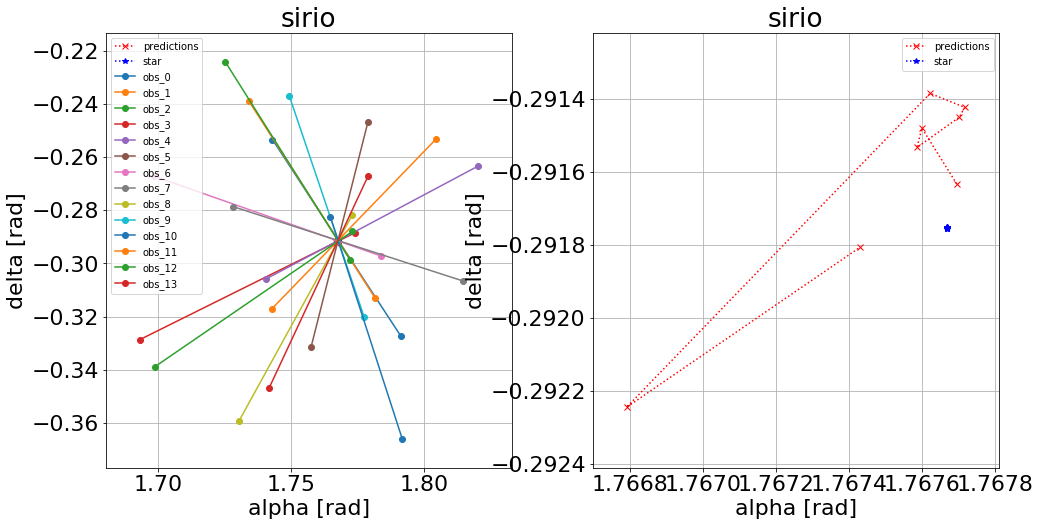

In [22]:
plot_observations(sirio, gaia, scanSirio)
plots = []
for x in [5,10,15,20]:
    p = plot_prediction_VS_reality(sirio, gaia, scanSirio, x, angle_tolerance=0.2)
    plots.append(p)
    p.savefig('figures/tmp/counting_'+str(x)+'observations',format='png',transparent=False,facecolor='w')

## data exploration and tests

gaia archive:

In [23]:
df = pd.read_csv('../data/GaiaSource_1584380076484244352_2200921635402776448.csv',
                 sep=None , delimiter=None, header='infer', engine='python', verbose=True, nrows=100)

In [24]:
df.head(0)

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper


In [25]:
# df['source_id'].value_counts()

**Autograd**

In [27]:
import autograd
from autograd import jacobian
from autograd import grad
import autograd.numpy as np
from autograd.extend import primitive, defvjp
from autograd.test_util import check_grads

def double_sin(x, y):
    out = np.array([np.sin(x), np.cos(y), 1])
    return out  # np.append(out, 2)


# print(double_sin( np.array([1,2]) ))
my_grad = jacobian(double_sin, argnum=0)
print(my_grad(np.pi, np.pi/2))

[-1. -0. -0.]


In [55]:
@primitive
def my_func(x):
    """Numerically stable log(sum(exp(x))), also defined in scipy.misc"""
    return np.sin(x)

def my_func_vjp(ans, x):
    x_shape = x.shape
    return lambda g: np.full(x_shape, g) * np.cos(x)

# Now we tell Autograd that logsumexmp has a gradient-making function.
defvjp(my_func, my_func_vjp)

der_my_func = jacobian(my_func)
for my_point in [np.array([np.pi]), np.array([np.pi/4]),  np.array([np.pi/2])]:
    print(der_my_func(my_point), np.cos(my_point))

[[-1.]] [-1.]
[[0.70710678]] [0.70710678]
[[6.123234e-17]] [6.123234e-17]


In [30]:
@primitive
def logsumexp(x):
    """Numerically stable log(sum(exp(x))), also defined in scipy.misc"""
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x - max_x)))

def logsumexp_vjp(ans, x):
    x_shape = x.shape
    return lambda g: np.full(x_shape, g) * np.exp(x - np.full(x_shape, ans))

# Now we tell Autograd that logsumexmp has a gradient-making function.
defvjp(logsumexp, logsumexp_vjp)

def example_func(y):
    z = y**2
    lse = logsumexp(z)
    return np.sum(lse)

grad_of_example = grad(example_func)
my_array = np.linspace(-10, 10, 10)
print('Shape of my array: {}'.format(my_array.shape))
print("Gradient: \n", grad_of_example(my_array))

# Check the gradients numerically, just to be safe.
check_grads(example_func, modes=['rev'])(my_array)

Shape of my array: (10,)
Gradient: 
 [-1.00000000e+01 -5.41430436e-17 -5.24119093e-30 -8.29707084e-39
 -1.42061150e-43  1.42061150e-43  8.29707084e-39  5.24119093e-30
  5.41430436e-17  1.00000000e+01]
